In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry.polygon import LinearRing
from shapely.geometry import box, Polygon
import time
import shapely.wkt
import matplotlib.pyplot as plt

In [3]:
import vbo_cleaner

In [ ]:
# Load neccessary datasets
vierkant = gpd.read_file("../Data/NLvierkant/NL_vierkant100m.shp")
df = pd.read_csv("woonplaats_grenzen.csv" , sep = ";")
vbo = pd.read_csv("VBO.csv", sep = ";", encoding = "utf-8", na_values = "NaN", on_bad_lines = "warn")
vbo = VBOCleaner(vbo)

In [5]:
class city_grid():
    def __init__(self, city_borders, grid, city):
        
        # Select only the city_borders of wanted city and transform geometry (string) to geometry object
        self.city_borders = city_borders[city_borders.woonplaats.str.contains(city)]
        self.city_borders.geometry = self.city_borders.geometry.apply(shapely.wkt.loads)
        
        self.grid = grid
        self.city = city
        self.union = LinearRing()
        self.df = gpd.GeoDataFrame()
    
    def border_fix(self, name):
        self.city_borders =  self.city_borders[~self.city_borders.woonplaats.str.contains(name)]
        
    
    def print_borders(self):
        print(self.city_borders)
    def create_union(self):
        for _, i in self.city_borders.iterrows():
            if not i.geometry.is_empty:
                x, y = i.geometry.xy
                self.union = self.union.union(i.geometry)
                plt.plot(x, y)
        plt.show()
        
    def create_grid(self):

        def create_box(bounds, distance):
            xmin, ymin, xmax, ymax = bounds
            xmin -= distance
            ymin -= distance
            xmax += distance
            ymax += distance

            return xmin, ymin, xmax, ymax


        boundbox = box(*create_box(self.union.bounds, 100))
        
        
        tot = len(self.grid)
        for i, v in self.grid.iterrows():
            print("{0:.1f}%".format((i / tot) * 100), end = "\r")
            if boundbox.contains(v.geometry):
                self.df = self.df.append(v)
    def join_vbo(self, vbo):
        
        
    def save_grid(self):
        self.df.to_csv("../Data/presnap/grid/" + self.city + "_grid.csv")

C:\Users\Gebruiker\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


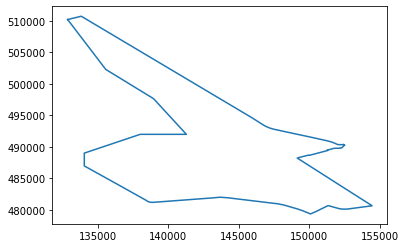

In [6]:
cg = city_grid( df, vierkant, "Almere")
cg.create_union()


In [ ]:
cg.create_grid()

In [9]:
cg.save_grid()

In [22]:
cg.city

'Tilburg'

In [17]:
x, y = cg.geometry.xy
plt.plot(x, y)
xbox, ybox = box(*create_box(cg.geometry.bounds, 1000)).exterior.xy

plt.plot(xbox, ybox)

AttributeError: 'city_grid' object has no attribute 'geometry'